In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

In [ ]:
data = pd.read_csv('/content/filtered_data.csv')

In [ ]:
data.head()

,carrier_code,flight_number,origin_airport,destination_airport,date,scheduled_elapsed_time,tail_number,departure_delay,arrival_delay,delay_carrier,...,HourlyStationPressure_x,HourlyVisibility_x,HourlyWindSpeed_x,STATION_y,HourlyDryBulbTemperature_y,HourlyPrecipitation_y,HourlyStationPressure_y,HourlyVisibility_y,HourlyWindSpeed_y,busiest
0,UA,6369,IAH,ELP,2019-05-27,124,N93305,-2,-9,0,...,29.74,10.0,15.0,7.227002e+10,84.0,0.0,25.78,10.0,29.0,1
1,UA,6352,IAH,OMA,2019-05-20,137,N93305,-8,-12,0,...,29.70,10.0,18.0,7.255001e+10,54.0,0.0,28.99,10.0,13.0,1
2,UA,6040,IAH,OKC,2019-05-14,90,N93305,-6,-14,0,...,29.90,10.0,11.0,7.235301e+10,76.0,0.0,28.61,10.0,11.0,1
3,UA,6201,IAD,ATL,2019-05-31,116,N93305,0,-7,0,...,29.47,10.0,14.0,7.221901e+10,87.0,0.0,28.82,10.0,15.0,1
4,UA,6343,IAH,ECP,2019-05-12,107,N93305,-7,16,0,...,29.79,10.0,8.0,7.207357e+10,75.0,0.0,29.77,10.0,9.0,1


In [ ]:
data['origin_airport'].value_counts().shape

(20,)

### Missing Values

In [ ]:
data['actual_departure_dt'].fillna('2019-07-31 11:36:00',inplace = True)
data['actual_arrival_dt'].fillna('2019-09-21 17:45:00',inplace = True)
data['STATION_x'].fillna(data['STATION_x'].mean(),inplace = True)
data['HourlyDryBulbTemperature_x'].fillna(data['HourlyDryBulbTemperature_x'].median(),inplace = True)
data['HourlyPrecipitation_x'].fillna(data['HourlyPrecipitation_x'].median(),inplace = True)
data['HourlyStationPressure_x'].fillna(data['HourlyStationPressure_x'].median(),inplace = True)
data['HourlyVisibility_x'].fillna(data['HourlyVisibility_x'].median(),inplace = True)
data['HourlyWindSpeed_x'].fillna(data['HourlyWindSpeed_x'].median(),inplace = True)
data['STATION_y'].fillna(data['STATION_y'].mean(),inplace = True)
data['HourlyDryBulbTemperature_y'].fillna(data['HourlyDryBulbTemperature_y'].median(),inplace = True)
col = ['HourlyPrecipitation_y','HourlyStationPressure_y','HourlyVisibility_y','HourlyWindSpeed_y']
for i in col :
  data[i].fillna(data[i].median(),inplace = True)

<ipython-input-46-fe7529910e1d>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['actual_departure_dt'].fillna('2019-07-31 11:36:00',inplace = True)
<ipython-input-46-fe7529910e1d>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, 

### IQR

In [ ]:
#  IQR
numeric_columns = data.select_dtypes(include=['int', 'float']).columns

iqr_outliers = {}

for col in numeric_columns:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]

    iqr_outliers[col] = {
        'Q1': Q1,
        'Q3': Q3,
        'IQR': IQR,
        'Lower Bound': lower_bound,
        'Upper Bound': upper_bound,
        'Outliers Count': outliers.shape[0]
    }

iqr_outliers_df = pd.DataFrame(iqr_outliers).T

In [ ]:
data['date'] = pd.to_datetime(data['date'], errors='coerce')
data['month'] = data['date'].dt.month
data.drop(columns = ['date'],axis =1, inplace = True)

In [ ]:
data['delay_weather'] = data['delay_weather']/60

In [ ]:
data['total_delay'] = data['delay_carrier'] + data['delay_weather'] + data['delay_national_aviation_system'] + data['delay_security'] + data['delay_late_aircarft_arrival'] + data['arrival_delay']

In [ ]:
data.drop(columns = ['arrival_delay','delay_carrier', 'delay_weather','delay_national_aviation_system', 'delay_security','delay_late_aircarft_arrival'],axis =1, inplace = True)

The `cancelled_code` column categorizes the reasons for flight cancellations:

- **N**: Indicates flights that were not cancelled.
- **A**: Denotes cancellations due to carrier-related issues (such as airline maintenance or staffing).
- **B**: Represents cancellations due to weather conditions.
- **C**: Signifies cancellations related to National Aviation System delays, which can include factors like air traffic control, airport operations, or other infrastructure-related issues.

In [ ]:
data['cancelled_code'] = data['cancelled_code'].map({'N' : 0,'A':1,'B':2,'C':3})

In [ ]:
data.drop(columns = ['year','day'],axis =1, inplace = True)

In [ ]:
data.drop(columns = ['departure_delay','scheduled_departure_dt', 'actual_departure_dt','scheduled_arrival_dt','actual_arrival_dt'], axis =1, inplace = True)

In [ ]:
def calculate_weather_severity_x(row):
    temperature_score = min(max((row['HourlyDryBulbTemperature_x'] - 69.886803) / 10, 0), 1)
    precipitation_score = min(row['HourlyPrecipitation_x'] / 2.690000, 1)
    pressure_score = min((30.480000	 - row['HourlyStationPressure_x']) / 1, 1)
    visibility_score = min(row['HourlyVisibility_x'] / 20.00, 1)
    wind_speed_score = min(row['HourlyWindSpeed_x'] / 40.00, 1)
    severity_index = (0.25 * temperature_score + 0.25 * precipitation_score + 0.2 * pressure_score + 0.15 * visibility_score + 0.15 * wind_speed_score)
    return severity_index

data['Weather_Severity_Index_x'] = data.apply(calculate_weather_severity_x, axis=1)

In [ ]:
def calculate_weather_severity_y(row):
    temperature_score = min(max((row['HourlyDryBulbTemperature_y'] - 70.235796) / 10, 0), 1)
    precipitation_score = min(row['HourlyPrecipitation_y'] / 3.860000, 1)
    pressure_score = min((30.490000 - row['HourlyStationPressure_y']) / 1, 1)
    visibility_score = min(row['HourlyVisibility_y'] / 10.00, 1)
    wind_speed_score = min(row['HourlyWindSpeed_y'] / 40.00, 1)

    # Calculate the weather severity index
    severity_index = (0.25 * temperature_score +
                      0.25 * precipitation_score +
                      0.2 * pressure_score +
                      0.15 * visibility_score +
                      0.15 * wind_speed_score)
    return severity_index

# Apply the function to the DataFrame
data['Weather_Severity_Index_y'] = data.apply(calculate_weather_severity_y, axis=1)

In [ ]:
data.drop(columns = ['HourlyDryBulbTemperature_x', 'HourlyPrecipitation_x','HourlyStationPressure_x', 'HourlyVisibility_x', 'HourlyWindSpeed_x','HourlyDryBulbTemperature_y', 'HourlyPrecipitation_y','HourlyStationPressure_y', 'HourlyVisibility_y', 'HourlyWindSpeed_y'],axis =1, inplace = True)

In [ ]:
import networkx as nx
num_flights = data.groupby(by=["origin_airport", "destination_airport"]).count()['flight_number']

num_flights.head()

origin_airport  destination_airport
ATL             ABQ                    2
                ACY                    2
                AUS                    8
                AVL                    2
                BDL                    2
Name: flight_number, dtype: int64

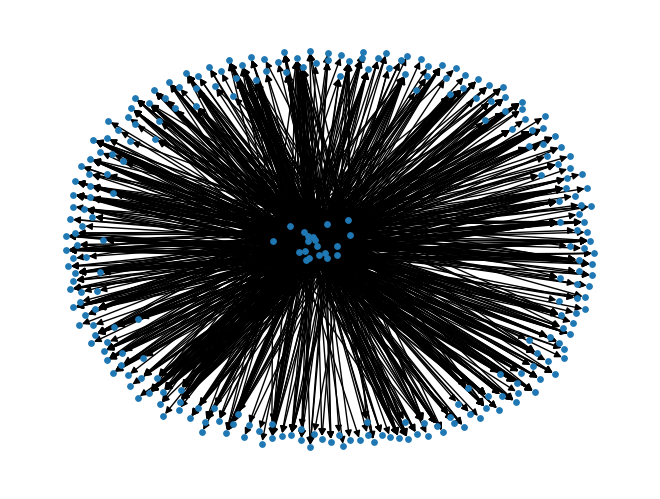

In [ ]:
g = nx.DiGraph()

for _, edge in num_flights.reset_index().iterrows():
    g.add_edge(edge['origin_airport'], edge['destination_airport'], weight=edge['flight_number'])
nx.draw(g,node_size=15)

In [ ]:
deg_cen = nx.degree_centrality(g)

airport, dc = [], []
for k in deg_cen:
    airport.append(k)
    dc.append(deg_cen[k])

df = {"airport": airport, "deg_cen": dc}

df_deg_cen = pd.DataFrame(df)
df_deg_cen.set_index("airport", inplace=True)

df_deg_cen.head()

,deg_cen
airport,
ATL,0.345865
ABQ,0.041353
ACY,0.007519
AUS,0.071429
AVL,0.015038


In [ ]:
bet_cen = nx.betweenness_centrality(g, weight="weight")

airport, bc = [], []
for k in bet_cen:
    airport.append(k)
    bc.append(bet_cen[k])

df = {"airport": airport, "bet_cen": bc}

df_bet_cen = pd.DataFrame(df)
df_bet_cen.set_index("airport", inplace=True)

df_bet_cen.head()

,bet_cen
airport,
ATL,0.000087
ABQ,0.000000
ACY,0.000000
AUS,0.000000
AVL,0.000000


In [ ]:
net_stats = df_deg_cen
net_stats["bet_cen"] = df_bet_cen.bet_cen
net_stats.reset_index(inplace=True)

net_stats.head()

,airport,deg_cen,bet_cen
0,ATL,0.345865,0.000087
1,ABQ,0.041353,0.000000
2,ACY,0.007519,0.000000
3,AUS,0.071429,0.000000
4,AVL,0.015038,0.000000


In [ ]:
net_stats[net_stats['airport'] == 'IAD']

,airport,deg_cen,bet_cen
28,IAD,0.281955,0.005964


In [ ]:
data['deg_cen'] = data['origin_airport'].map(net_stats.set_index('airport').deg_cen)
data['bet_cen'] = data['origin_airport'].map(net_stats.set_index('airport').bet_cen)

In [ ]:
data.head()

,carrier_code,flight_number,origin_airport,destination_airport,scheduled_elapsed_time,tail_number,cancelled_code,month,weekday,STATION_x,STATION_y,busiest,total_delay,Weather_Severity_Index_x,Weather_Severity_Index_y,deg_cen,bet_cen
0,UA,6369,IAH,ELP,124,N93305,0,5,0,7.224301e+10,7.227002e+10,1,-9.0,0.52925,0.708750,0.421053,0.010171
1,UA,6352,IAH,OMA,137,N93305,0,5,0,7.224301e+10,7.255001e+10,1,-12.0,0.54850,0.398750,0.421053,0.010171
2,UA,6040,IAH,OKC,90,N93305,0,5,1,7.224301e+10,7.235301e+10,1,-14.0,0.48225,0.535355,0.421053,0.010171
3,UA,6201,IAD,ATL,116,N93305,0,5,4,7.240309e+10,7.221901e+10,1,-7.0,0.57750,0.656250,0.281955,0.005964
4,UA,6343,IAH,ECP,107,N93305,0,5,6,7.224301e+10,7.207357e+10,1,32.0,0.32083,0.446855,0.421053,0.010171


In [ ]:
data.drop(columns = ['busiest'], axis =1, inplace = True)

In [ ]:
# Categorize flight numbers by ranges (adjust based on airline patterns if known)
bins = [0, 999, 1999, 2999, 3999, 4999]
labels = ['Domestic Short-Haul', 'Domestic Long-Haul', 'International Short-Haul', 'International Long-Haul', 'Special']
data['flight_category'] = pd.cut(data['flight_number'], bins=bins, labels=labels)

# Calculate average delay by flight category
delay_by_category = data.groupby('flight_category')['total_delay'].mean()
delay_by_category.head()

,total_delay
flight_category,
Domestic Short-Haul,15.268793
Domestic Long-Haul,14.415157
International Short-Haul,20.395842
International Long-Haul,18.701613
Special,15.782599


In [ ]:
data.head()

,carrier_code,flight_number,origin_airport,destination_airport,scheduled_elapsed_time,tail_number,cancelled_code,month,weekday,STATION_x,STATION_y,total_delay,Weather_Severity_Index_x,Weather_Severity_Index_y,deg_cen,bet_cen,flight_category
0,UA,6369,IAH,ELP,124,N93305,0,5,0,7.224301e+10,7.227002e+10,-9.0,0.52925,0.708750,0.421053,0.010171,NaN
1,UA,6352,IAH,OMA,137,N93305,0,5,0,7.224301e+10,7.255001e+10,-12.0,0.54850,0.398750,0.421053,0.010171,NaN
2,UA,6040,IAH,OKC,90,N93305,0,5,1,7.224301e+10,7.235301e+10,-14.0,0.48225,0.535355,0.421053,0.010171,NaN
3,UA,6201,IAD,ATL,116,N93305,0,5,4,7.240309e+10,7.221901e+10,-7.0,0.57750,0.656250,0.281955,0.005964,NaN
4,UA,6343,IAH,ECP,107,N93305,0,5,6,7.224301e+10,7.207357e+10,32.0,0.32083,0.446855,0.421053,0.010171,NaN


In [ ]:
data_numerical = data.select_dtypes(include = ['int64','float64'])
data_categorical = data.select_dtypes(include = ['object'])

In [ ]:
data_numerical.head()

,flight_number,scheduled_elapsed_time,cancelled_code,weekday,STATION_x,STATION_y,total_delay,Weather_Severity_Index_x,Weather_Severity_Index_y,deg_cen,bet_cen
0,6369,124,0,0,7.224301e+10,7.227002e+10,-9.0,0.52925,0.708750,0.421053,0.010171
1,6352,137,0,0,7.224301e+10,7.255001e+10,-12.0,0.54850,0.398750,0.421053,0.010171
2,6040,90,0,1,7.224301e+10,7.235301e+10,-14.0,0.48225,0.535355,0.421053,0.010171
3,6201,116,0,4,7.240309e+10,7.221901e+10,-7.0,0.57750,0.656250,0.281955,0.005964
4,6343,107,0,6,7.224301e+10,7.207357e+10,32.0,0.32083,0.446855,0.421053,0.010171


In [ ]:
data_categorical.head()

,carrier_code,origin_airport,destination_airport,tail_number
0,UA,IAH,ELP,N93305
1,UA,IAH,OMA,N93305
2,UA,IAH,OKC,N93305
3,UA,IAD,ATL,N93305
4,UA,IAH,ECP,N93305


<Axes: >

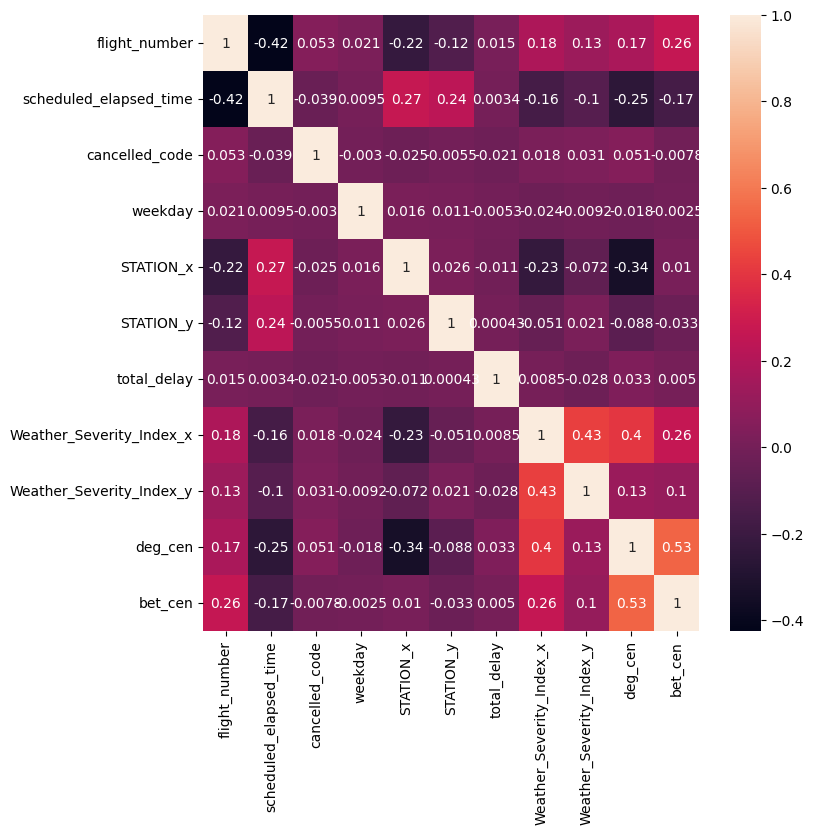

In [ ]:
plt.figure(figsize = (8,8))
sns.heatmap(data_numerical.corr(),annot = True)

In [ ]:
data_numerical['total_delay'].describe()

,total_delay
count,7816.000000
mean,16.936125
std,85.981981
min,-56.000000
25%,-15.000000
50%,-6.000000
75%,7.000000
max,1380.000000


In [ ]:
count =0
for i in range(len(data_numerical)) :
  if data['total_delay'][i] < 0 :
    count = count+1

In [ ]:
data['flight_number'].value_counts().head(10)

,count
flight_number,
553,16
552,13
434,13
679,13
1631,13
2680,13
2279,12
1677,12
534,12


In [ ]:
data.groupby(['origin_airport','destination_airport'])['flight_number'].count().head()

origin_airport  destination_airport
ATL             ABQ                     2
                ACY                     2
                AUS                     8
                AVL                     2
                BDL                     2
                                       ..
                TPA                    13
                TTN                     1
                TUS                     2
BOS             ATL                    13
                AUS                     1
Name: flight_number, Length: 75, dtype: int64

In [ ]:
delay_day = data.groupby('weekday')['total_delay'].mean()

<Axes: xlabel='weekday'>

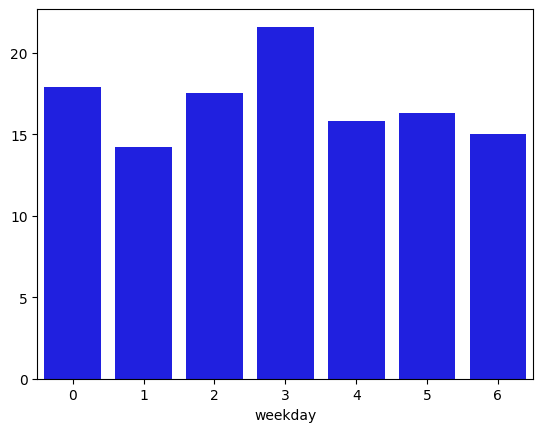

In [ ]:
sns.barplot(x = delay_day.index, y = delay_day.values,color = 'blue')

In [ ]:
data_numerical.head()

,flight_number,scheduled_elapsed_time,cancelled_code,weekday,STATION_x,STATION_y,total_delay,Weather_Severity_Index_x,Weather_Severity_Index_y,deg_cen,bet_cen
0,6369,124,0,0,7.224301e+10,7.227002e+10,-9.0,0.52925,0.708750,0.421053,0.010171
1,6352,137,0,0,7.224301e+10,7.255001e+10,-12.0,0.54850,0.398750,0.421053,0.010171
2,6040,90,0,1,7.224301e+10,7.235301e+10,-14.0,0.48225,0.535355,0.421053,0.010171
3,6201,116,0,4,7.240309e+10,7.221901e+10,-7.0,0.57750,0.656250,0.281955,0.005964
4,6343,107,0,6,7.224301e+10,7.207357e+10,32.0,0.32083,0.446855,0.421053,0.010171


In [ ]:
data_numerical.drop(columns = ['flight_number','STATION_x','STATION_y'], axis =1, inplace = True)

In [ ]:
data_numerical.head()

,scheduled_elapsed_time,cancelled_code,weekday,total_delay,Weather_Severity_Index_x,Weather_Severity_Index_y,deg_cen,bet_cen
0,124,0,0,-9.0,0.52925,0.708750,0.421053,0.010171
1,137,0,0,-12.0,0.54850,0.398750,0.421053,0.010171
2,90,0,1,-14.0,0.48225,0.535355,0.421053,0.010171
3,116,0,4,-7.0,0.57750,0.656250,0.281955,0.005964
4,107,0,6,32.0,0.32083,0.446855,0.421053,0.010171


In [ ]:
X = data_numerical.drop(columns = ['total_delay'], axis =1)
y = data_numerical['total_delay']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train.shape

(6252, 7)

In [ ]:
X_test.shape

(1564, 7)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_ss = scaler.fit_transform(X_train)
X_test_ss = scaler.transform(X_test)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components= 2)
X_train_pca = pca.fit_transform(X_train_ss)
X_test_pca = pca.transform(X_test_ss)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

In [ ]:
lr_model = LinearRegression()
lr_model.fit(X_train_pca, y_train)
lr_pred = lr_model.predict(X_test_pca)
lr_mse = mean_squared_error(y_test, lr_pred)
lr_r2 = r2_score(y_test, lr_pred)
print(f"Linear Regression MSE: {lr_mse}")
print(f"Linear Regression R2 Score: {lr_r2}")

Linear Regression MSE: 8303.494782506694
Linear Regression R2 Score: -0.0027587128613490997


In [ ]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_pca, y_train)
rf_pred = rf_model.predict(X_test_pca)
rf_mse = mean_squared_error(y_test, rf_pred)
rf_r2 = r2_score(y_test, rf_pred)
print(f"Random Forest MSE: {rf_mse}")
print(f"Random Forest R2 Score: {rf_r2}")

Random Forest MSE: 9514.691812416222
Random Forest R2 Score: -0.14902705005501926


In [ ]:
param_grid = {
    'n_estimators': [50, 100, 200],            # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],           # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],           # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4]              # Minimum number of samples required to be at a leaf node
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train_pca, y_train)

# Get the best model and parameters
best_rf = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Make predictions with the best model
y_pred = best_rf.predict(X_test_pca)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


KeyboardInterrupt: 